# XGBOOST na szybko

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_transactions = pd.read_json('../data/transactions.json', lines=True)
df_users = pd.read_csv('../data/users.csv')
df_merchants = pd.read_csv('../data/merchants.csv')

In [60]:
# --------- Temporal data feature engineering

df_transactions['hour'] = df_transactions['timestamp'].dt.hour
df_transactions['day_of_week'] = df_transactions['timestamp'].dt.dayofweek  # 0=Monday
df_transactions['is_weekend'] = df_transactions['day_of_week'] >= 5
df_transactions['month'] = df_transactions['timestamp'].dt.month

# Time Since Last Transaction: User-level
df_transactions = df_transactions.sort_values(['user_id', 'timestamp'])
df_transactions['time_since_last_user_txn'] = (
    df_transactions.groupby('user_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

# Time Since Last Transaction: Merchant-level
df_transactions = df_transactions.sort_values(['merchant_id', 'timestamp'])
df_transactions['time_since_last_merchant_txn'] = (
    df_transactions.groupby('merchant_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

#TODO: time since last transaction: user-merchant level

In [3]:
# --------- Geo-data feature engineering
# Extract latitude and longitude into separate columns
df_transactions['latitude'] = df_transactions['location'].apply(lambda x: x['lat'])
df_transactions['longitude'] = df_transactions['location'].apply(lambda x: x['long'])
df_transactions.drop(columns=['location'], inplace=True)

### To Be Continued...

df_transactions.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,latitude,longitude
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,debit_card,1,145,0,0,40.057938,14.959737
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,debit_card,1,32,1,0,42.059350,1.596625
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,credit_card,1,604,1,0,50.923432,21.795262
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,credit_card,0,1031,1,0,56.833396,-9.881566
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,credit_card,1,330,0,0,54.042996,2.168516


In [4]:
df_merged = pd.merge(df_transactions, df_users, on='user_id', how='left')

# Then, join the result with df_merchants on merchant_id
df_merged = pd.merge(df_merged, df_merchants, on='merchant_id', how='left')


In [5]:

df_merged['signup_date'] = pd.to_datetime(df_merged['signup_date'], errors='coerce')

# Seconds since 1970
df_merged['signup_timestamp'] = df_merged['signup_date'].view('int64') / 10**9  # Convert to seconds


C:\Users\laura\AppData\Local\Temp\ipykernel_9212\1917890169.py:4: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_merged['signup_timestamp'] = df_merged['signup_date'].view('int64') / 10**9  # Convert to seconds


In [6]:
df_merged = df_merged.drop(columns=["trust_score", "risk_score"])

In [64]:
df_merged['signup_timestamp']

0         1.627344e+09
1         1.589328e+09
2         1.728000e+09
3         1.626739e+09
4         1.633046e+09
              ...     
499995    1.733875e+09
499996    1.617581e+09
499997    1.656202e+09
499998    1.626134e+09
499999    1.647475e+09
Name: signup_timestamp, Length: 500000, dtype: float64

In [7]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   transaction_id                  500000 non-null  object        
 1   timestamp                       500000 non-null  datetime64[ns]
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  object        
 6   currency                        500000 non-null  object        
 7   device                          500000 non-null  object        
 8   payment_method                  500000 non-null  object        
 9   is_international                500000 non-null  int64         
 10  session_length_seconds          500000 non-null  int64  

In [8]:
df_merged.columns

Index(['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount',
       'channel', 'currency', 'device', 'payment_method', 'is_international',
       'session_length_seconds', 'is_first_time_merchant', 'is_fraud',
       'latitude', 'longitude', 'age', 'sex', 'education',
       'primary_source_of_income', 'sum_of_monthly_installments',
       'sum_of_monthly_expenses', 'country_x', 'signup_date', 'category',
       'country_y', 'number_of_alerts_last_6_months', 'avg_transaction_amount',
       'account_age_months', 'has_fraud_history', 'signup_timestamp'],
      dtype='object')

In [9]:
cols_to_drop = ['transaction_id','user_id','timestamp','merchant_id','signup_date']

In [10]:
df_merged = df_merged.drop(columns=cols_to_drop)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = df_merged.drop('is_fraud',axis=1)
y = df_merged['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
df_merged.columns

Index(['amount', 'channel', 'currency', 'device', 'payment_method',
       'is_international', 'session_length_seconds', 'is_first_time_merchant',
       'is_fraud', 'latitude', 'longitude', 'age', 'sex', 'education',
       'primary_source_of_income', 'sum_of_monthly_installments',
       'sum_of_monthly_expenses', 'country_x', 'category', 'country_y',
       'number_of_alerts_last_6_months', 'avg_transaction_amount',
       'account_age_months', 'has_fraud_history', 'signup_timestamp'],
      dtype='object')

In [72]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   amount                          500000 non-null  float64
 1   channel                         500000 non-null  object 
 2   currency                        500000 non-null  object 
 3   device                          500000 non-null  object 
 4   payment_method                  500000 non-null  object 
 5   is_international                500000 non-null  int64  
 6   session_length_seconds          500000 non-null  int64  
 7   is_first_time_merchant          500000 non-null  int64  
 8   is_fraud                        500000 non-null  int64  
 9   hour                            500000 non-null  int32  
 10  day_of_week                     500000 non-null  int32  
 11  is_weekend                      500000 non-null  bool   
 12  month           

In [14]:
categorical_columns = ['channel','currency','device', 'payment_method', 'sex', 'education', 'primary_source_of_income','country_x','country_y','category']

In [15]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = class_weight_dict[1] / class_weight_dict[0]  


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',        
    'eta': 0.1,                      
    'max_depth': 6,                   
    'subsample': 0.8,                 
    'colsample_bytree': 0.8,         
    'scale_pos_weight': scale_pos_weight  
}

num_round = 100  
bst = xgb.train(params, dtrain, num_round)


y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5696666666666667
Confusion Matrix:
 [[78941 58131]
 [ 6419  6509]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.58      0.71    137072
           1       0.10      0.50      0.17     12928

    accuracy                           0.57    150000
   macro avg       0.51      0.54      0.44    150000
weighted avg       0.85      0.57      0.66    150000



Feature Importance (using weight):
{'amount': 441.0, 'channel': 63.0, 'device': 54.0, 'payment_method': 67.0, 'is_international': 47.0, 'session_length_seconds': 547.0, 'is_first_time_merchant': 34.0, 'latitude': 481.0, 'longitude': 476.0, 'age': 357.0, 'sex': 52.0, 'education': 85.0, 'primary_source_of_income': 115.0, 'sum_of_monthly_installments': 446.0, 'sum_of_monthly_expenses': 469.0, 'country_x': 175.0, 'category': 113.0, 'country_y': 158.0, 'number_of_alerts_last_6_months': 128.0, 'avg_transaction_amount': 396.0, 'account_age_months': 404.0, 'has_fraud_history': 45.0, 'signup_timestamp': 475.0}


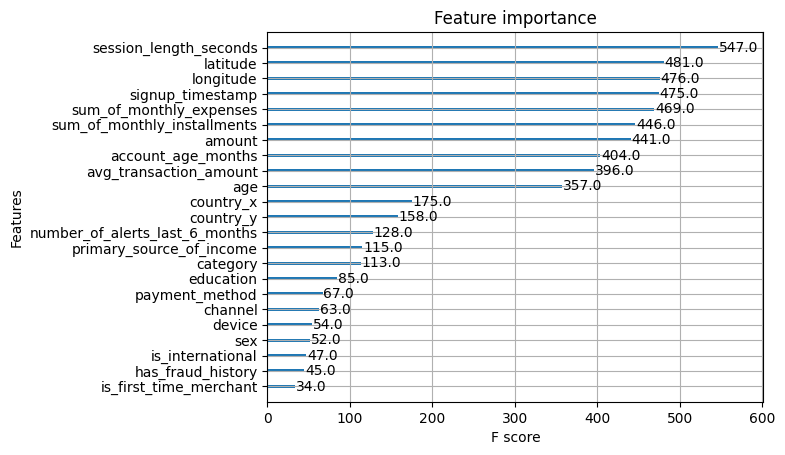

In [16]:
importance = bst.get_score(importance_type='weight')  


print("Feature Importance (using weight):")
print(importance)


xgb.plot_importance(bst, importance_type='weight') 
plt.show()

### Everything time related important as fuck, geolocation also